In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
from scipy.integrate import quad
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import copy
import calendar
from optimise_GDD_fctns import * #Phenology_set, run_GDD_and_get_RMSE, run_GDD_and_get_RMSE_derivs, plot_profiles_at_minimum, get_station_locations, put_ERA5_in_array

#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [ ]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5.csv')
for vble in ['photoperiod', 'DTF', 'dev stage', 'vpd', 'ssrd', 't2max', 't2min', 'tp']:
    ds_inputs_DE = ds_inputs_DE.drop(columns = [col for col in ds_inputs_DE.columns if vble in col])

In [ ]:
for code in range(80, 90):
    print(ds_inputs_DE.loc[ds_inputs_DE['Naturraumgruppe_Code'] == code, 'Naturraumgruppe'].unique())

['Odertal']
['Mittelbrandenburgische Platten und Niederungen']
['Ostbrandenburgisches Heide- und Seengebiet']
['Spreewald']
['Lausitzer Becken- und Heideland']
['Fläming']
['Altmark']
['Elbtalniederung']
['Elbe-Mulde-Tiefland']
['Oberlausitzer Heideland']


<Axes: xlabel='Naturraumgruppe_Code', ylabel='Count'>

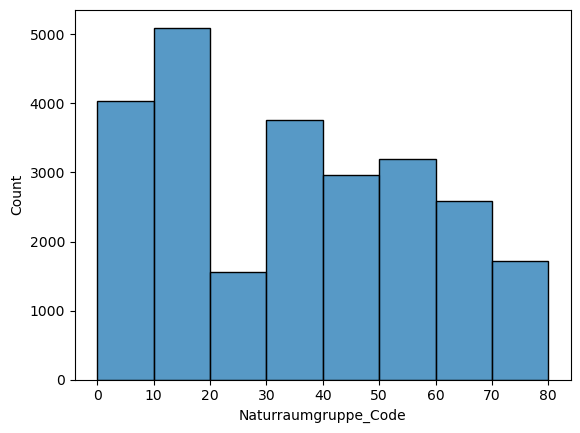

In [ ]:
sns.histplot(ds_inputs_DE['Naturraumgruppe_Code'], bins = np.arange(0, 90, 10))

In [ ]:
def optimise_and_plot_nature_regions(ds):
    x1s = [np.array([0.5, 8, 23, 39])]#28
    fm_varieties = []
    comparison_array_varieties = []
    for i, nature_code in enumerate([0, 10, 20, 30, 40, 50, 60, 70]):
        title_extra = ['Alpine', 'Saarland/black forest', 'Rheinland', 'Harz mountains/middle German mountains', 'Saxony/Thuringia hills', 'Middle Germany', 'Marsh/moor', 'Baltic coast region', 'Brandenburg'][i]
        print(nature_code, title_extra)
        ds_inputs_region = ds.loc[ds_inputs_DE['Naturraumgruppe_Code'] // 10 == nature_code // 10]
        train, test = train_test_split(ds_inputs_region, test_size=0.2, random_state = 1)#fm_variety[-2:]#
        fm_variety = local_opt(x1s, train, test,# ds_variety, 
                            lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                            great_threshold = 13, response_type = 'Wang',
                            phase_list = ['beginning of flowering'],
                            method='Nelder-Mead',
                            thresholds = [20], growing_period_length=300,
                            test_size = 0.2, random_state=1)
        print(fm_variety[0][0])
        comparison_array_variety = run_GDD(fm_variety[0][0], test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                            thresholds = [20], title_extra=title_extra, method = 'regression', plot=True)
        fm_varieties.append(fm_variety)
        comparison_array_varieties.append(comparison_array_variety)
    return fm_varieties, comparison_array_varieties

In [ ]:
fm_varieties, comparison_array_varieties = optimise_and_plot_nature_regions(ds_inputs_DE)

In [ ]:
FAO_sorts_string = ds_inputs_DE['SORTE'].str.split(' ').str.get(-1)
FAO_sorts_string = FAO_sorts_string*(1 - FAO_sorts_string.str.contains(r'[a-zA-Z]', regex=True))
FAO_sorts_string.replace('', np.nan, inplace = True)
FAO_sorts_string.fillna(0, inplace=True)
FAO_sorts_string = FAO_sorts_string.astype(np.int64)
ds_inputs_DE['FAO_sort'] = FAO_sorts_string

In [ ]:
ds_inputs_DE.loc[ds_inputs_DE['FAO_sort'] == 0, 'FAO_sort'] = (ds_inputs_DE.loc[ds_inputs_DE['FAO_sort'] == 0, 'SILOREIFEZAHL'] + ds_inputs_DE.loc[ds_inputs_DE['FAO_sort'] == 0, 'KOERNERREIFEZAHL'])/2

In [ ]:
early_threshold = 220
ei_threshold = 225
il_threshold = 250
ds_inputs_DE_early = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] > 0)*(ds_inputs_DE['FAO_sort'] < early_threshold)]
print(len(ds_inputs_DE_early))
ds_inputs_DE_ei = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] >= early_threshold)*(ds_inputs_DE['FAO_sort'] <= ei_threshold)]
print(len(ds_inputs_DE_ei))
ds_inputs_DE_il = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] > ei_threshold)*(ds_inputs_DE['FAO_sort'] < il_threshold)]
print(len(ds_inputs_DE_il))
ds_inputs_DE_late = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] >= il_threshold)]
print(len(ds_inputs_DE_late))


2803
3492
4434
3161


In [ ]:
def optimise_and_plot_varieties(ds, thresholds):
    early_threshold = thresholds[0]
    ei_threshold = thresholds[1]
    il_threshold = thresholds[2]
    ds_early = ds.loc[(ds['FAO_sort'] > 0)*(ds['FAO_sort'] < early_threshold)]
    print(len(ds_early), ' in early category')
    ds_ei = ds.loc[(ds['FAO_sort'] >= early_threshold)*(ds['FAO_sort'] <= ei_threshold)]
    print(len(ds_ei), ' in early intermediate category')
    ds_il = ds.loc[(ds['FAO_sort'] > ei_threshold)*(ds['FAO_sort'] < il_threshold)]
    print(len(ds_il), ' in intermediate late category')
    ds_late = ds.loc[(ds['FAO_sort'] >= il_threshold)]
    print(len(ds_late), ' in late category')
    x1s = [np.array([0.5, 8, 23, 39])]#28
    print('Optimising early varieties')
    fm_varieties = []
    comparison_array_varieties = []
    for i, ds_variety in enumerate([ds_early, ds_ei, ds_il, ds_late]):
        title_extra = ['Early varieties', 'Early intermediate varieties', 'Intermediate late varieties', 'Late varieties'][i]
        train, test = train_test_split(ds_variety, test_size=0.2, random_state = 1)#fm_variety[-2:]#
        fm_variety = local_opt(x1s, train, test,# ds_variety, 
                            lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                            great_threshold = 13, response_type = 'Wang',
                            phase_list = ['beginning of flowering'],
                            method='Nelder-Mead',
                            thresholds = [20], growing_period_length=300,
                            test_size = 0.2, random_state=1)
        print(fm_variety[0][0])
        comparison_array_variety = run_GDD(fm_variety[0][0], test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                            thresholds = [20], title_extra='Early varieties', method = 'regression', plot=True)
        fm_varieties.append(fm_variety)
        comparison_array_varieties.append(comparison_array_variety)
    return fm_varieties, comparison_array_varieties

In [ ]:
print('Early varieties mean flowering time: ', ds_inputs_DE_early['observed time to beginning of flowering'].dt.days.mean(),
      '\nEarly intermediate varieties mean flowering time: ', ds_inputs_DE_ei['observed time to beginning of flowering'].dt.days.mean(),
      '\nIntermediate late varieties mean flowering time: ', ds_inputs_DE_il['observed time to beginning of flowering'].dt.days.mean(),
      '\nLate varieties mean flowering time: ', ds_inputs_DE_late['observed time to beginning of flowering'].dt.days.mean())

Early varieties mean flowering time:  88.29004637887977 
Early intermediate varieties mean flowering time:  87.86454753722795 
Intermediate late varieties mean flowering time:  86.93820478123591 
Late varieties mean flowering time:  85.77886744701044


In [ ]:
print('Early varieties mean planting date: ', pd.to_datetime(ds_inputs_DE_early['Planting date']).dt.dayofyear.mean(),
      '\nEarly intermediate varieties mean planting date: ', pd.to_datetime(ds_inputs_DE_ei['Planting date']).dt.dayofyear.mean(),
      '\nIntermediate late varieties mean planting date: ', pd.to_datetime(ds_inputs_DE_il['Planting date']).dt.dayofyear.mean(),
      '\nLate varieties mean planting date: ', pd.to_datetime(ds_inputs_DE_late['Planting date']).dt.dayofyear.mean())

Early varieties mean planting date:  119.5693899393507 
Early intermediate varieties mean planting date:  118.8479381443299 
Intermediate late varieties mean planting date:  117.94136220117275 
Late varieties mean planting date:  117.12496045555204


In [ ]:
print('Early varieties mean flowering date: ', pd.to_datetime(ds_inputs_DE_early['Planting date']).dt.dayofyear.mean() + ds_inputs_DE_early['observed time to beginning of flowering'].dt.days.mean(),
        '\nEarly intermediate varieties mean flowering date: ', pd.to_datetime(ds_inputs_DE_ei['Planting date']).dt.dayofyear.mean() + ds_inputs_DE_ei['observed time to beginning of flowering'].dt.days.mean(),
        '\nIntermediate late varieties mean flowering date: ', pd.to_datetime(ds_inputs_DE_il['Planting date']).dt.dayofyear.mean() + ds_inputs_DE_il['observed time to beginning of flowering'].dt.days.mean(),
        '\nLate varieties mean flowering date: ', pd.to_datetime(ds_inputs_DE_late['Planting date']).dt.dayofyear.mean() + ds_inputs_DE_late['observed time to beginning of flowering'].dt.days.mean())

Early varieties mean flowering date:  207.85943631823045 
Early intermediate varieties mean flowering date:  206.71248568155784 
Intermediate late varieties mean flowering date:  204.87956698240868 
Late varieties mean flowering date:  202.90382790256248


2803  in early category
3492  in early intermediate category
4434  in intermediate late category
3161  in late category
Optimising early varieties
Optimization terminated successfully.
         Current function value: 8.171364
         Iterations: 76
         Function evaluations: 166
[ 0.5  8.  23.  39. ] [ 0.34790744  7.02222445 23.7504802  39.01890724] [ 0.15209256  0.97777555 -0.7504802  -0.01890724]
RMSE at opt on test set:  7.983382920294498
R^2: 0.45361327382827554
[ 0.34790744  7.02222445 23.7504802  39.01890724]
0 stations out of 561 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.453613273828277
Bias: 0.016932457637080518 (sign 1.0)
Variance of modelled values: 68.18707028265847
Optimization terminated successfully.
         Current function value: 8.343545
         Iterations: 72
         Function evaluations: 154
[ 0.5  8.  23.  39. ] [ 0.37278326  7.1090662  24.48921521 39.01028249] [ 0.12721674  0.8909338  -1.48921521 -0.01028249]
RMSE at op

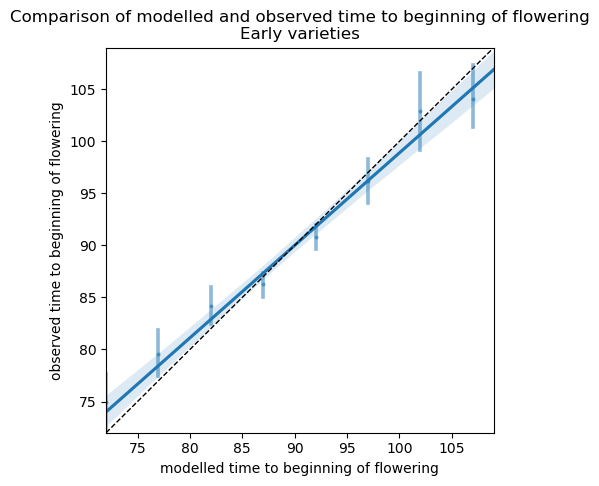

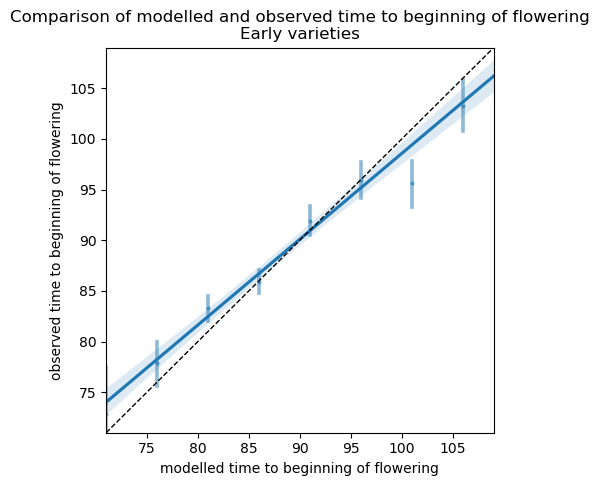

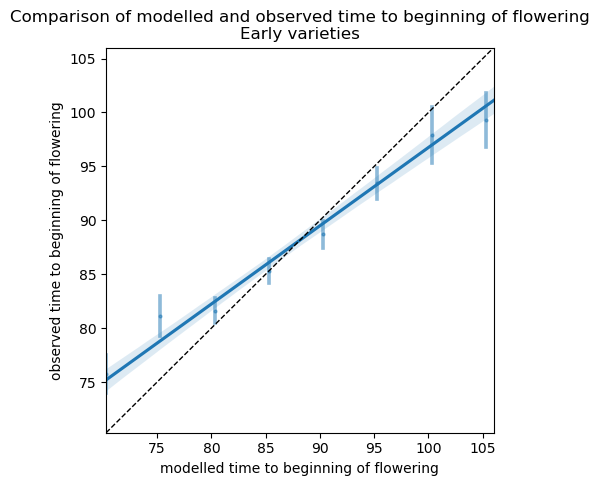

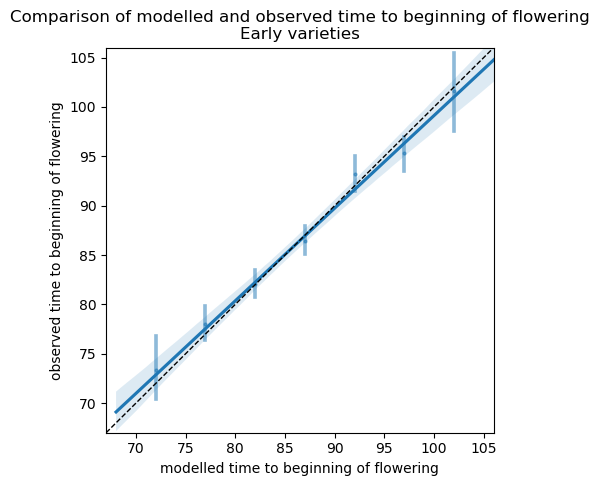

In [ ]:
fm_varieties, comparison_array_varieties = optimise_and_plot_varieties(ds_inputs_DE, [220, 225, 250])

In [ ]:
print(len(ds_inputs_varieties.loc[cols_in_other(ds_inputs_varieties, separate_params, ['Referenzjahr', 'Stations_id'])]),
      len(ds_inputs_varieties.loc[~cols_in_other(ds_inputs_varieties, separate_params, ['Referenzjahr', 'Stations_id'])]),
      len(ds_inputs_varieties))

In [ ]:
separate_params = pd.concat(comparison_array_varieties, ignore_index=True)

In [ ]:
x1s = [np.array([0.5, 8, 28, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
test_b = ds_inputs_varieties.loc[cols_in_other(ds_inputs_varieties, separate_params, ['Referenzjahr', 'Stations_id'])]
train_b = ds_inputs_varieties.loc[~cols_in_other(ds_inputs_varieties, separate_params, ['Referenzjahr', 'Stations_id'])]
fm_flowering_all_DE_all = local_opt(x1s, train_b, test_b,# ds_inputs_DE_early, 
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 1)

Optimization terminated successfully.
         Current function value: 8.365664
         Iterations: 116
         Function evaluations: 233
[ 0.5  8.  28.  39. ] [ 0.3209848   7.03557583 22.5648775  38.50246086] [0.1790152  0.96442417 5.4351225  0.49753914]
RMSE at opt on test set:  8.32105330216998
R^2: 0.4318997536927227


In [ ]:
ds_inputs_varieties = pd.concat([ds_inputs_DE_early, ds_inputs_DE_ei, ds_inputs_DE_il, ds_inputs_DE_late], ignore_index=True)